### 03: Hidden State Trajectory Analysis

**Building on attention patterns, moving onto analysing how token representation evolve across layers**

In [2]:
# Importing necessary libraries
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings("ignore")
# Setting random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Loading the same model
model = "EleutherAI/gpt-neo-125M"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForCausalLM.from_pretrained(
    model,
    output_attentions=True,
    output_hidden_states=True,
).to(device)
config = model.config


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading weights: 100%|██████████| 160/160 [00:00<00:00, 507.55it/s, Materializing param=transformer.wte.weight]                         
GPTNeoForCausalLM LOAD REPORT from: EleutherAI/gpt-neo-125M
Key                                                   | Status     |  | 
------------------------------------------------------+------------+--+-
transformer.h.{0, 2, 4, 6, 8, 10}.attn.attention.bias | UNEXPECTED |  | 
transformer.h.{0...11}.attn.attention.masked_bias     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


1. Generating text to extract hidden states

In [5]:
# Prompt to analyze attention patterns
prompt = "The Eiffel Tower is located in Paris, France. It is a famous tourist site."
inputs = tokenizer(prompt, return_tensors="pt").to(device)
input_length = inputs['input_ids'].shape[1]
print(f"Prompt: '{prompt}'")
print(f"Input tokens: {tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])}")
print(f"Number of input tokens: {input_length}")

Prompt: 'The Eiffel Tower is located in Paris, France. It is a famous tourist site.'
Input tokens: ['The', 'ĠE', 'iff', 'el', 'ĠTower', 'Ġis', 'Ġlocated', 'Ġin', 'ĠParis', ',', 'ĠFrance', '.', 'ĠIt', 'Ġis', 'Ġa', 'Ġfamous', 'Ġtourist', 'Ġsite', '.']
Number of input tokens: 19


In [6]:
# Generating text and capturing hidden states
with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=40,
        do_sample=False,
        repetition_penalty=10.0,
        return_dict_in_generate=True,
        output_attentions=True,
        output_hidden_states=True,
    )

generated_text = tokenizer.decode(output.sequences[0])
print(f"\nGenerated text:\n{generated_text}")
print(f"\nGeneration steps: {len(output.hidden_states)}")
print(f"Layers per step: {len(output.hidden_states[0])}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Generated text:
The Eiffel Tower is located in Paris, France. It is a famous tourist site. The Eiffel tower was built by the French architect Louis-Philippe de Beaumont in 1871 and named after him (the first person to be born there).
It has been used

Generation steps: 40
Layers per step: 13


2. Extarcting trajectories

In [ ]:
def extract_token_trajectories(hidden_states, step_idx=0):
    """
    Extract representation trajectory for each token across all layers.
    Args:
        hidden_states: list of length num_steps, each containing a list of length num_layers with tensors of shape (batch_size, seq_len, hidden_size)
        step_idx: index of the generation step to analyze (0 for initial input)
    Returns:
        trajectories: shape (num_tokens, num_layers, hidden_size)
    """
    num_layers = len(hidden_states[step_idx])  # 13 (embedding + 12 layers)
    num_tokens = hidden_states[step_idx][0].shape[1]  # sequence length
    hidden_size = hidden_states[step_idx][0].shape[2]
    trajectories = torch.zeros(num_tokens, num_layers, hidden_size)
    for layer_idx in range(num_layers):
        trajectories[:, layer_idx, :] = hidden_states[step_idx][layer_idx][0]  # [seq_len, hidden_size]
    return trajectories
trajectories = extract_token_trajectories(output.hidden_states)
print(f"Trajectory shape: {trajectories.shape}")  

Trajectory shape: torch.Size([19, 13, 768])


Tracking 19 tokens x 13 layers and 768 dimensions

3. Geometric Analysis: Norms and Cosine Similarity

In [8]:
def compute_trajectory_metrics(trajectories):
    """
    Compute geometric properties of representation trajectories.
    Args:
        trajectories: shape (num_tokens, num_layers, hidden_size)
    Returns:
        A dictionary containing norms, cosine similarities, and distances.
    """
    num_tokens, num_layers, hidden_size = trajectories.shape
    # Applying L2 norms per layer
    norms = torch.norm(trajectories, p=2, dim=2)  # (num_tokens, num_layers)
    # Cosine similarity between consecutive layers
    cos_sim = torch.zeros(num_tokens, num_layers - 1)
    for t in range(num_tokens):
        for l in range(num_layers - 1):
            cos_sim[t, l] = torch.nn.functional.cosine_similarity(
                trajectories[t, l].unsqueeze(0),
                trajectories[t, l+1].unsqueeze(0)
            )
    # Euclidean distance between consecutive layers
    distances = torch.zeros(num_tokens, num_layers - 1)
    for t in range(num_tokens):
        for l in range(num_layers - 1):
            distances[t, l] = torch.norm(
                trajectories[t, l] - trajectories[t, l+1], p=2
            )
    metrics = {
        'norms': norms,
        'cos_similarity': cos_sim,
        'distances': distances
    }
    return metrics
metrics = compute_trajectory_metrics(trajectories)
print("Metrics computed:")
print(f"  Norms shape: {metrics['norms'].shape}")
print(f"  Cosine similarity shape: {metrics['cos_similarity'].shape}")
print(f"  Distances shape: {metrics['distances'].shape}")

Metrics computed:
  Norms shape: torch.Size([19, 13])
  Cosine similarity shape: torch.Size([19, 12])
  Distances shape: torch.Size([19, 12])


We have 13 norms, one per layer, 12 similarities and 13 distances

4. Visualizing norm evolution across layers

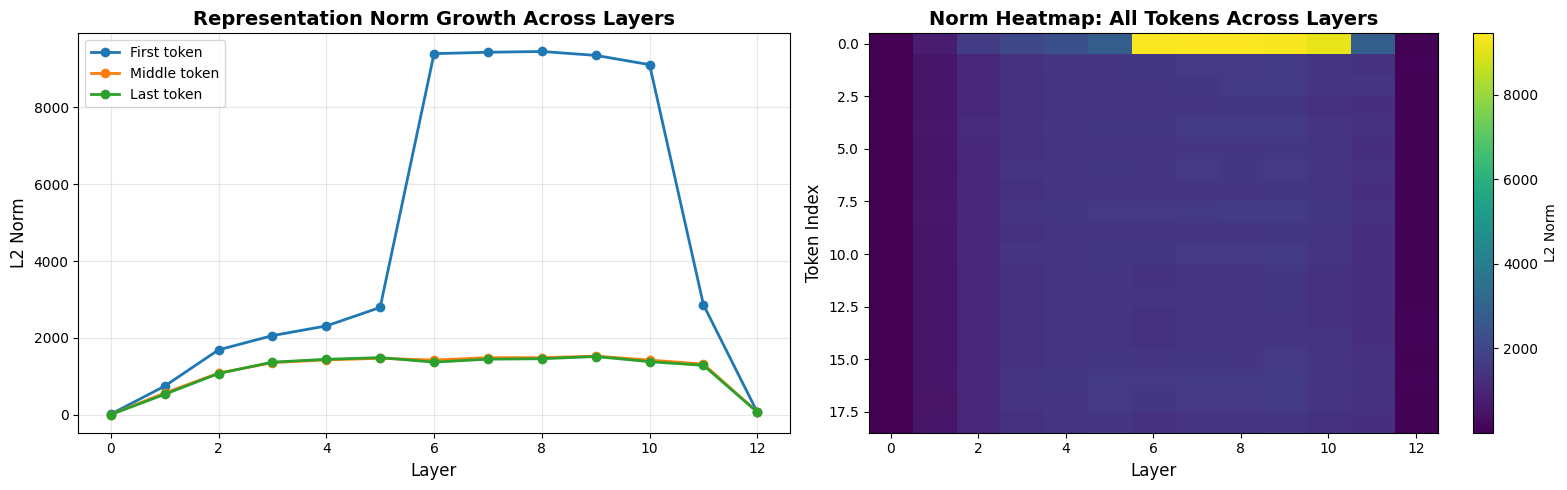

In [25]:
# Norm growth across layers for selected tokens
num_tokens = trajectories.shape[0]
token_indices = [0, num_tokens // 2, num_tokens - 1]
token_labels = ['First token', 'Middle token', 'Last token']
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Individual token trajectories
for idx, label in zip(token_indices, token_labels):
    axes[0].plot(range(13), metrics['norms'][idx].cpu().numpy(), 
                 marker='o', linewidth=2, label=label)
axes[0].set_xlabel('Layer', fontsize=12)
axes[0].set_ylabel('L2 Norm', fontsize=12)
axes[0].set_title('Representation Norm Growth Across Layers', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
# All tokens (heatmap)
im = axes[1].imshow(metrics['norms'].cpu().numpy(), aspect='auto', cmap='viridis')
axes[1].set_xlabel('Layer', fontsize=12)
axes[1].set_ylabel('Token Index', fontsize=12)
axes[1].set_title('Norm Heatmap: All Tokens Across Layers', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[1], label='L2 Norm')
plt.tight_layout()
plt.show()

1. Norm growth across layers:
- First token spikes dramatically to 10k in layers 6-8, then dips back down by layer 12
- Middle and last tokens show steady, monotonic growth from ~0 to ~1,500 with no unusual behavior
- The contrasting patterns reveal two distinct computational roles: aggregator (first token) vs. content processors (others)
2. Heatmap across tokens
- Baseline across rows 2-18 shows all content tokens follow nearly identical norm evolution
- Single bright yellow stripe at token 0, layers 6-8 visualizes the temporary aggregation spike
- Uniform coloring within each column (layer) indicates synchronized processing across tokens, except during the middle-layer aggregator phase.

**Conclusion**

- This first-token norm explosion directly correlates with heavy first-token attention in layers 6-8 found in notebook 02
- The hub-and-spoke architecture is now confirmed both geometrically (norms) and informationally (attention)

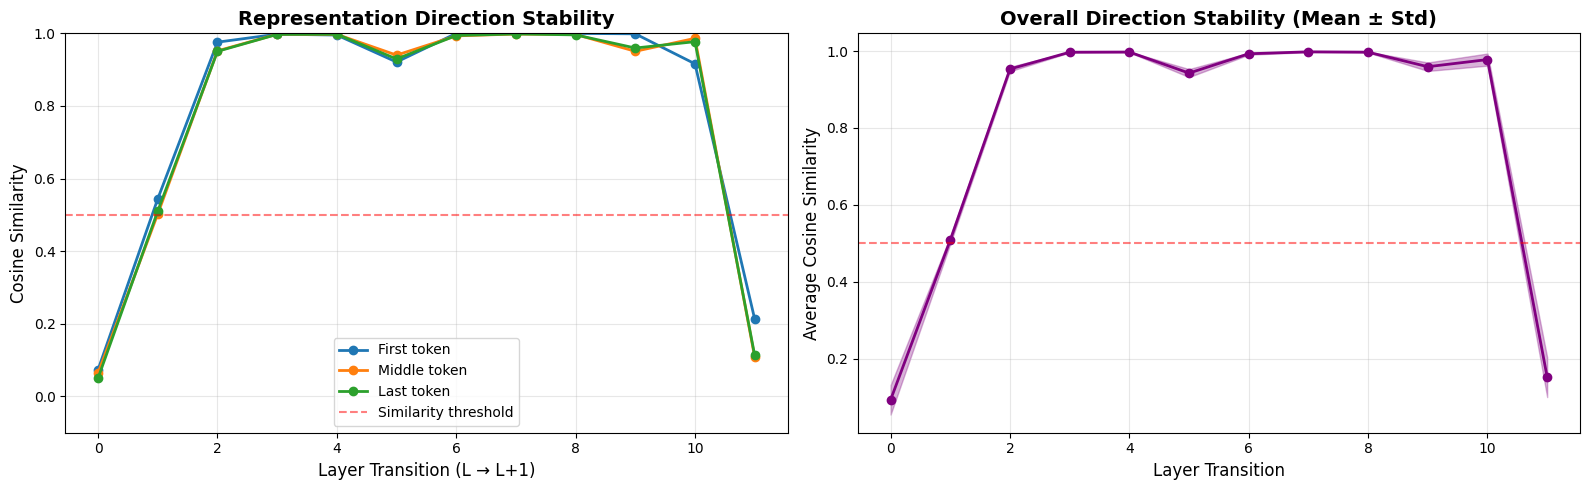


Mean cosine similarity across layers: 0.797
Layers with high stability (>0.8): 9 / 12
Layers with major direction shifts (<0.5): 2 / 12


In [ ]:
# Cosine similarity between layers
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Individual token cosine similarity
for idx, label in zip(token_indices, token_labels):
    axes[0].plot(range(12), metrics['cos_similarity'][idx].cpu().numpy(), 
                 marker='o', linewidth=2, label=label)
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Similarity threshold')
axes[0].set_xlabel('Layer Transition (L → L+1)', fontsize=12)
axes[0].set_ylabel('Cosine Similarity', fontsize=12)
axes[0].set_title('Representation Direction Stability', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([-0.1, 1.0])
# Average cosine similarity across all tokens
avg_cos_sim = metrics['cos_similarity'].mean(dim=0).cpu().numpy()
std_cos_sim = metrics['cos_similarity'].std(dim=0).cpu().numpy()
axes[1].plot(range(12), avg_cos_sim, marker='o', linewidth=2, color='purple')
axes[1].fill_between(range(12), avg_cos_sim - std_cos_sim, avg_cos_sim + std_cos_sim, 
                       alpha=0.3, color='purple')
axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Layer Transition', fontsize=12)
axes[1].set_ylabel('Average Cosine Similarity', fontsize=12)
axes[1].set_title('Overall Direction Stability (Mean ± Std)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print(f"\nMean cosine similarity across layers: {avg_cos_sim.mean():.3f}")
print(f"Layers with high stability (>0.8): {(avg_cos_sim > 0.8).sum()} / 12")
print(f"Layers with major direction shifts (<0.5): {(avg_cos_sim < 0.5).sum()} / 12")

- All three tokens track nearly identically throughout the transitions, rising from ~0.06 
  at layer 0, stabilizing near 1.0 through the middle layers, then dropping sharply at 
  layer 11.
- The average cosine similarity across all directions shows the same pattern with a tight 
  standard deviation band.

**Conclusion**
- Representation directions are highly stable through middle layers but undergo dramatic 
  geometric reorganization at the boundaries, and since this holds across all token 
  positions and directions, it is a model-wide structural property, not noise.

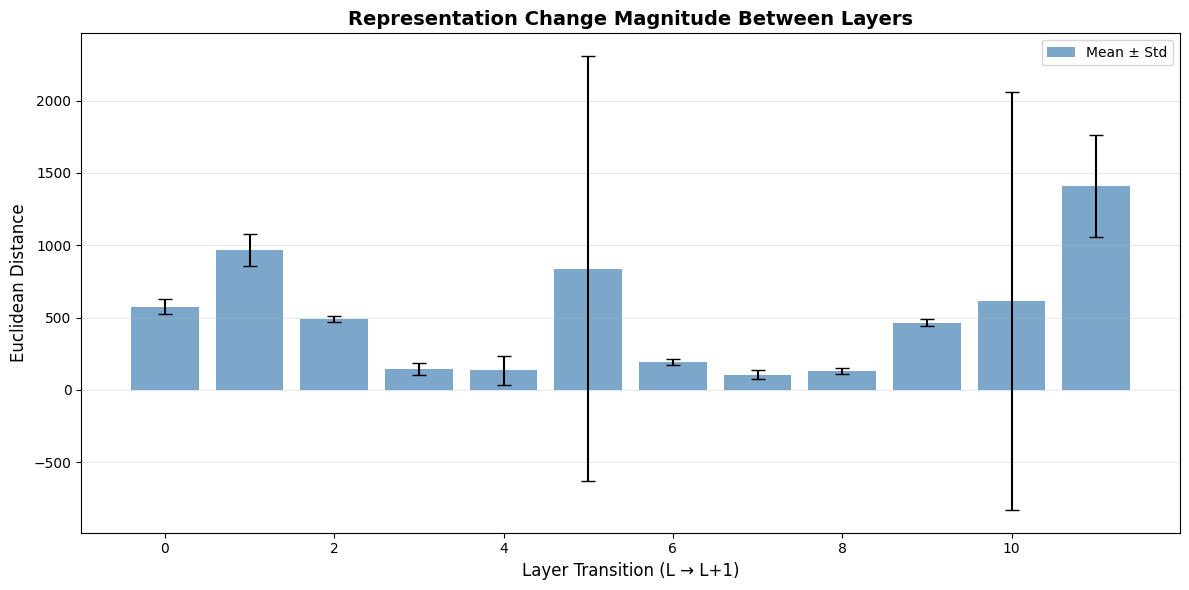


Layers with largest representation changes:
  1. Layer 11 to 12: 1408.311
  2. Layer 1 to 2: 967.692
  3. Layer 5 to 6: 837.993
  4. Layer 10 to 11: 615.869
  5. Layer 0 to 1: 574.747


In [19]:
# Distance between layers
fig, ax = plt.subplots(figsize=(12, 6))
avg_distance = metrics['distances'].mean(dim=0).cpu().numpy()
std_distance = metrics['distances'].std(dim=0).cpu().numpy()
ax.bar(range(12), avg_distance, alpha=0.7, color='steelblue', yerr=std_distance, 
       capsize=5, label='Mean ± Std')
ax.set_xlabel('Layer Transition (L → L+1)', fontsize=12)
ax.set_ylabel('Euclidean Distance', fontsize=12)
ax.set_title('Representation Change Magnitude Between Layers', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
sorted_layers = np.argsort(avg_distance)[::-1]
print("\nLayers with largest representation changes:")
for i, layer in enumerate(sorted_layers[:5]):
    print(f"  {i+1}. Layer {layer} to {layer+1}: {avg_distance[layer]:.3f}")

- The largest representation changes occur at the boundary layers (0->1,10->11,11->12), consistent with the cosine similarity findings.
- Layer 5->6 shows a notable mid-network spike (~838) with extremely high variance, suggesting inconsistent but sometimes large transformations at that transition.
- Middle layers (3->4, 7->8, 8->9) show the smallest changes (~100–150), confirming the stable geometric plateau seen in the direction stability plots.

**Conclusion**

- Euclidean distance between layers mirrors the cosine similarity pattern: the model makes its largest representational shifts at the input and output boundaries, while the middle layers process within a stable, low-change regime. The high variance at layer 5→6 suggests this transition may serve a distinct functional role worth 
investigating further.

Do certain layers have similar reprsentation properties? 

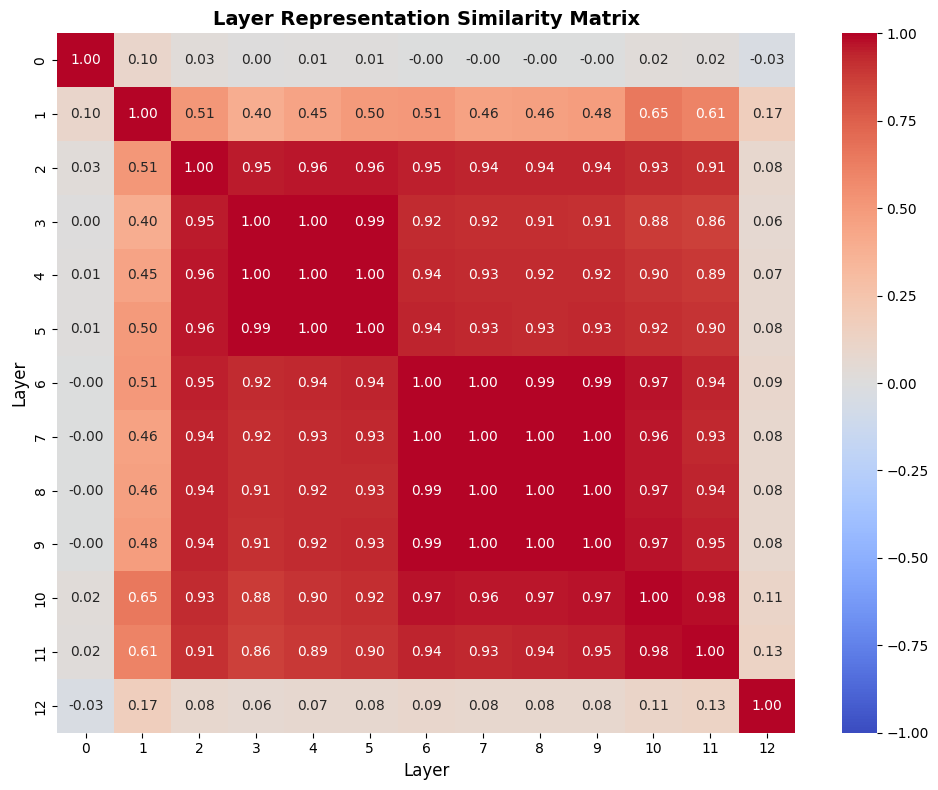

In [21]:
# Computing average representation per layer (across all tokens)
layer_avg_reps = trajectories.mean(dim=0)  # (13, 768)
# Computing pairwise cosine similarity between layers
layer_similarity = torch.zeros(13, 13)
for i in range(13):
    for j in range(13):
        layer_similarity[i, j] = torch.nn.functional.cosine_similarity(
            layer_avg_reps[i].unsqueeze(0),
            layer_avg_reps[j].unsqueeze(0)
        )
plt.figure(figsize=(10, 8))
sns.heatmap(layer_similarity.cpu().numpy(), annot=True, fmt='.2f', cmap='coolwarm',
            xticklabels=range(13), yticklabels=range(13), vmin=-1, vmax=1)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Layer', fontsize=12)
plt.title('Layer Representation Similarity Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

- *Layers 0 and 12* are isolated, near-zero similarity with all other layers, confirming they occupy unique representational spaces (raw input and final output).

- *Layers 2–9* form one broad high-similarity block (0.91–1.00), meaning the bulk of the network shares a stable geometric space. Within this, layers 6–9 are marginally tighter (0.99–1.00) than layers 2–5, hinting at a subtle mid-network shift.

- *Layer 1* is transitional (~0.40–0.65 with the main block), bridging the raw embedding and the stable processing regime.

**Conclusion**
- Most computation (layers 2–9) occurs within a shared representational geometry. 
- The meaningful transformations happen at the boundaries 0->1 and 11->12 consistent with the Euclidean distance and cosine stability findings.